In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
%matplotlib inline

In [ ]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)                       # in this gaussian blur we apply the standar deviation of X and Y directions
    # Gaussian Noise is a statistical noise having a probability density function equal to normal distribution, also known as Gaussian Distribution.

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    # For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value.
    #The function cv.threshold is used to apply the thresholding.
    #The first argument is the source image, which should be a grayscale image.
    #The second argument is the threshold value which is used to classify the pixel values.
    #The third argument is the maximum value which is assigned to pixel values exceeding the threshold.

    thresh = cv2.erode(thresh, None, iterations=2)
    #cv2.erode() method is used to perform erosion on the image.
    #The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object.
    #It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).
    thresh = cv2.dilate(thresh, None, iterations=2)
    #This operation is the sister of dilation. It computes a local minimum over the area of given kernel.
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)

    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
        cv2_imshow(image)

    return new_image

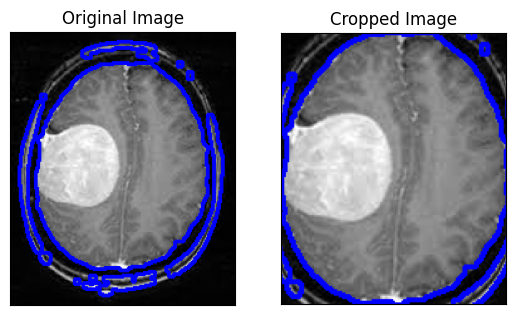

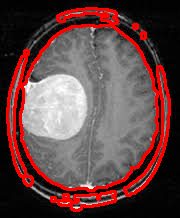

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    i=0
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            # only for plotting single preprocessed brain image image
            if (i==0):
              image = crop_brain_contour(image, plot=False)
              i=i+1
            else:
              image = crop_brain_contour(image, plot=False)

            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            #If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation.
            #For shrinking the image, INTER_AREA interpolation.
            #Cubic interpolation is computationally more complex, and hence slower than linear interpolation.
            #However, the quality of the resulting image will be higher.

            # normalize values
            image = image / 255.

            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [ ]:
augmented_data_path='/content/drive/MyDrive/augmented data/'
augmented_yes =augmented_data_path + 'yes'
augmented_no = augmented_data_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


In [ ]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

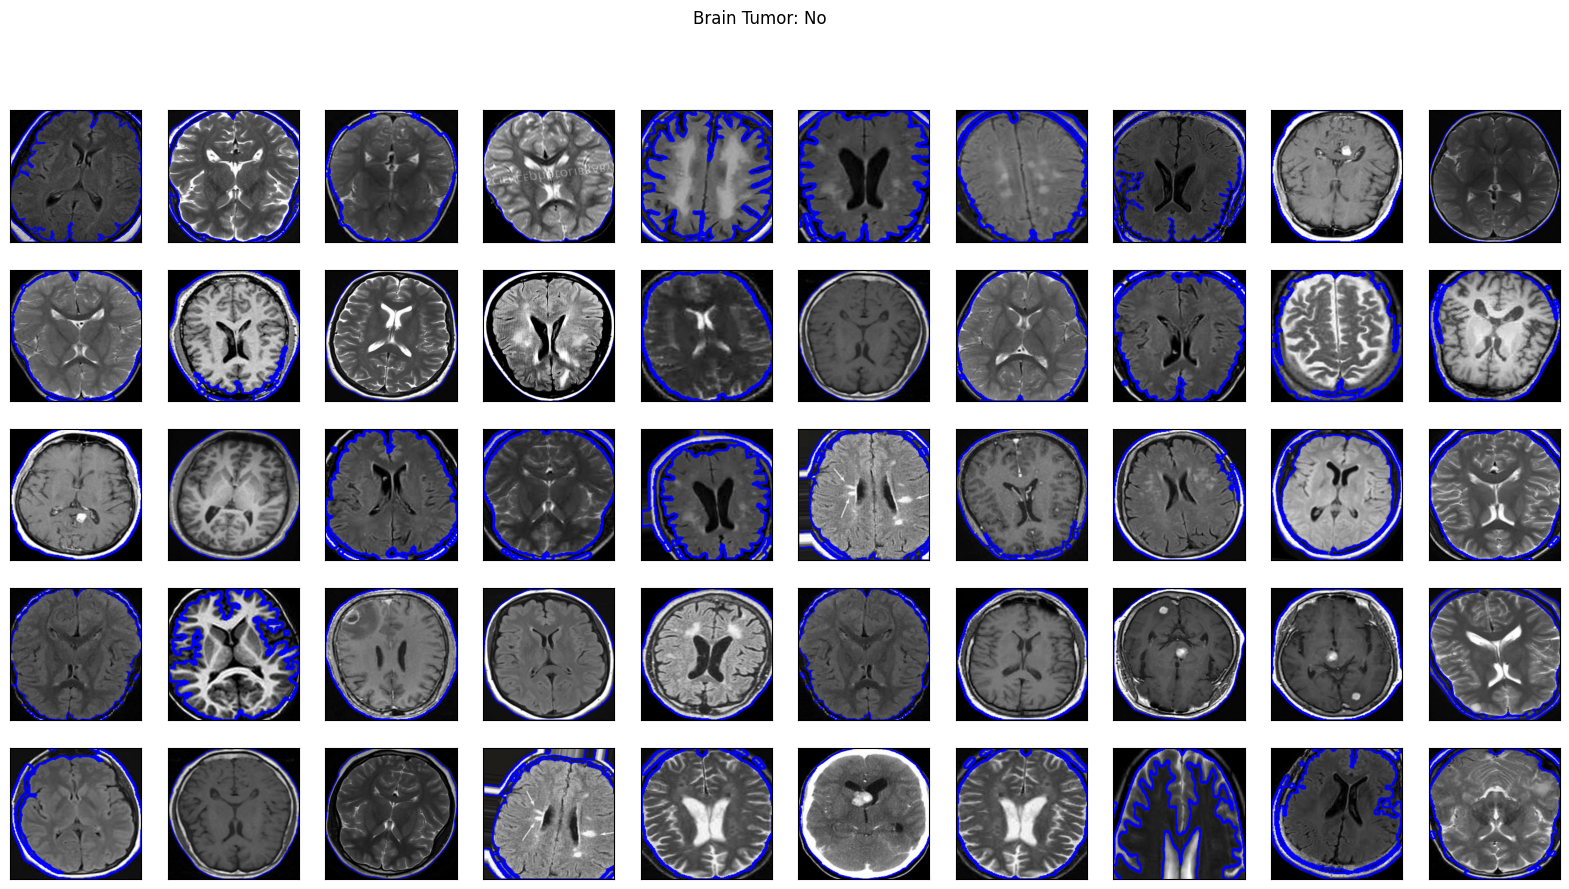

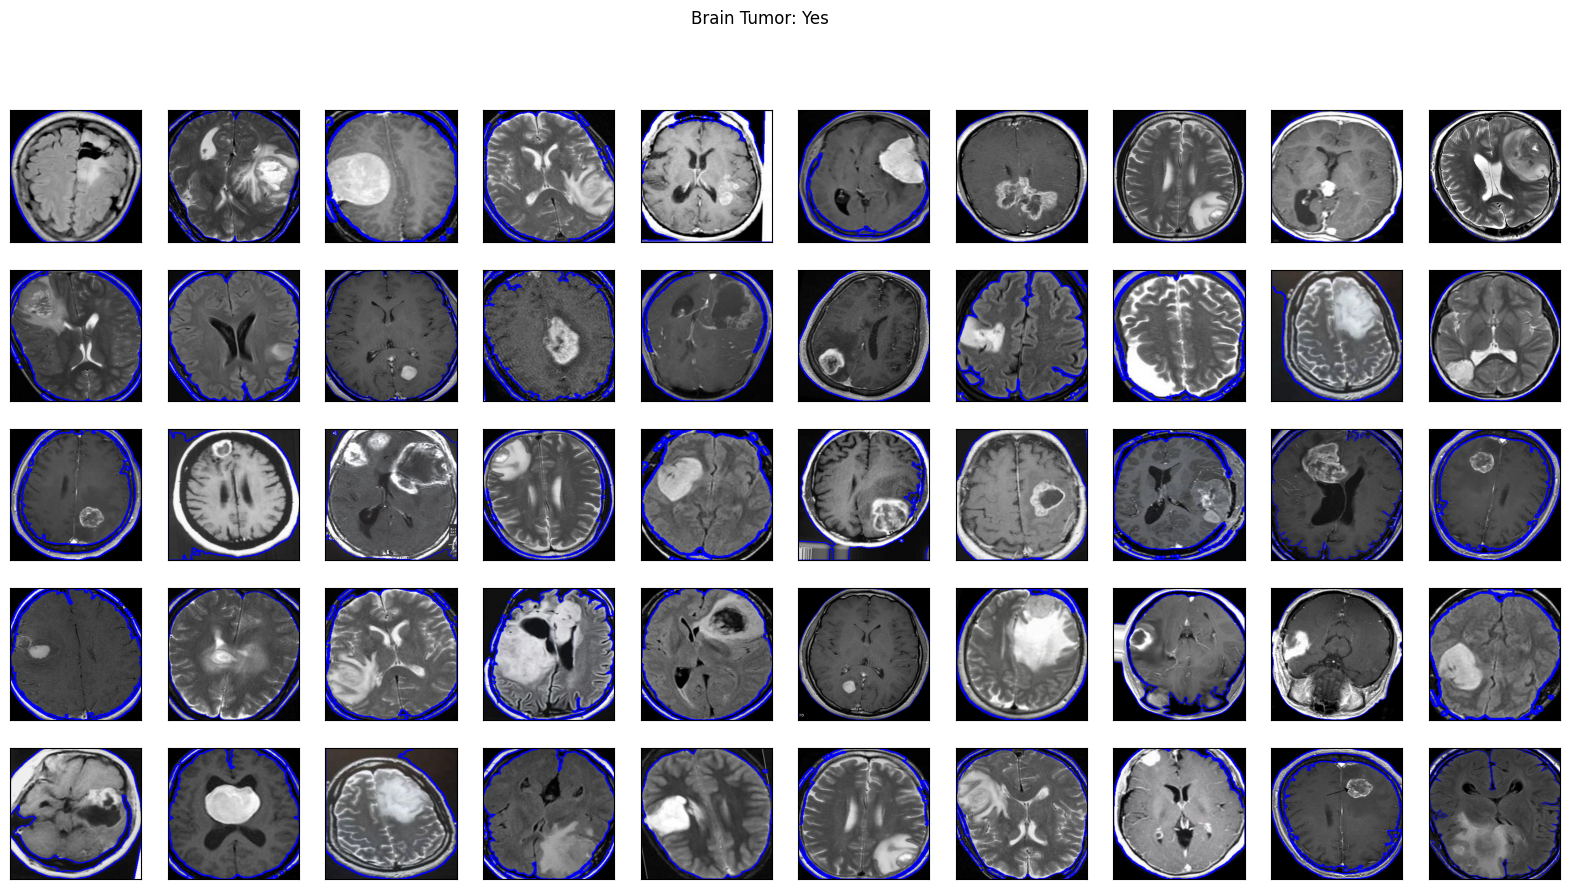

In [ ]:
plot_sample_images(X, y)

In [ ]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [ ]:
from keras.layers.regularization.dropout import Dropout
def brain_detection_model(input_shape):
    # Load pre-trained VGG model
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

    # Freeze the layers in the pre-trained VGG model
    for layer in vgg_model.layers:
        layer.trainable = False

    # Create a new input layer for your specific input shape
    input_layer = Input(shape=input_shape)

    # Use the pre-trained VGG model to extract features from your input
    x = vgg_model(input_layer)

    # Add your custom layers on top of the pre-trained VGG model
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    # Create a new model using the input layer and your custom layers
    model = Model(inputs=input_layer, outputs=x)

    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = brain_detection_model(IMG_SHAPE)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trai

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early = EarlyStopping(monitor='val_loss', patience=3)
model.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val),callbacks = [early])
model.save("/content/drive/MyDrive/models/VGG16model.h5")


In [ ]:
history = model.history.history

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    plt.savefig('graph1.png')

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('graph.png')

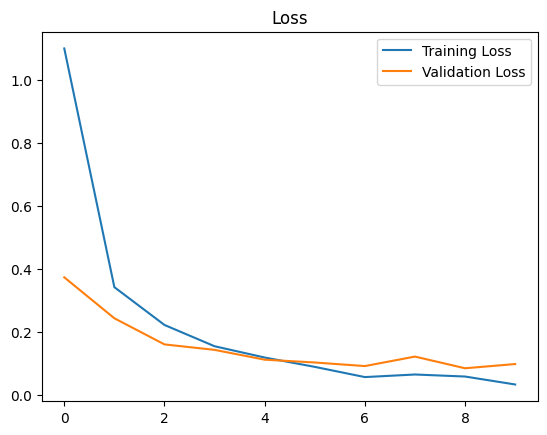

<Figure size 640x480 with 0 Axes>

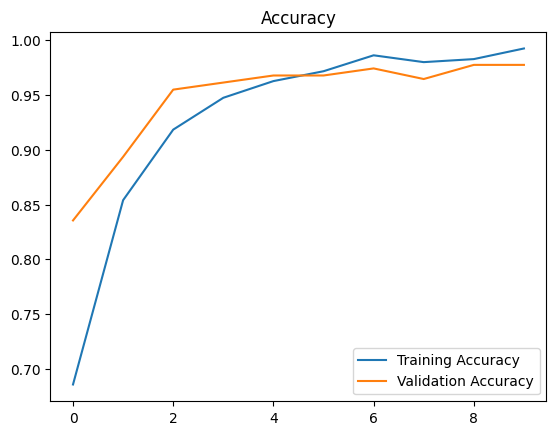

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_metrics(history)


In [ ]:
best_model = load_model(filepath='/content/drive/MyDrive/models/VGG16model.h5')

In [ ]:
best_model.metrics_names

['loss', 'accuracy']

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 2s 147ms/step - loss: 0.0577 - accuracy: 0.9871


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.057689279317855835
Test Accuracy = 0.9870967864990234


In [ ]:
y_pred = best_model.predict(X_test)
# print(y_pred)
y_pred_prob_test = np.where(y_pred > 0.5, 1, 0)
# print(y_pred_prob_test)
np.array_equal(y_pred_prob_test, y_test, equal_nan=True)
error = np.mean( y_pred_prob_test !=y_test )
print(error)

10/10 [==============================] - 1s 145ms/step
0.012903225806451613


In [ ]:
print(classification_report(y_test,y_pred_prob_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       134
           1       1.00      0.98      0.99       176

    accuracy                           0.99       310
   macro avg       0.99      0.99      0.99       310
weighted avg       0.99      0.99      0.99       310



In [ ]:
test_img1 = cv2.imread('/content/drive/MyDrive/augmented data/no/aug_No11_0_3388.jpg')
test_img = cv2.imread('/content/drive/MyDrive/augmented data/no/aug_10 no_0_415.jpg')
print(test_img.shape)
test_img = cv2.resize(test_img,(240,240))
test_img.shape
image_array = np.array(image)
image_array = image_array / 255.0
test_img=np.expand_dims(test_img,axis=0)
test_img.shape


(201, 173, 3)


(1, 240, 240, 3)

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/models/VGG16model.h5")
prediction = model.predict(test_img)
if prediction[0, 0] > 0.5:
    print("Tumor Found")
else:
    print("Tumor Not Found")
PLT


1/1 [==============================] - 0s 163ms/step
Tumor Not Found


In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Load and preprocess the image
image_path = "/content/drive/MyDrive/no/1 no.jpeg"
image = Image.open(image_path)
image = image.resize((240, 240))  # Resize the image to match the input size of the model
image_array = np.array(image)     # Convert the image to a NumPy array
image_array = image_array / 255.0  # Normalize pixel values between 0 and 1
width, height = image.size
num_channel = len(image_path.split())
print(num_channel)
print(image.size)
# Prepare the image for prediction
input_image = np.expand_dims(image_array, axis=0)  # Add a batch dimension
print(input_image.shape)

# Load the trained binary classification model
model = tf.keras.models.load_model("/content/drive/MyDrive/models/VGG16model.h5")

# # Make the prediction
# prediction = model.predict(input_image)

# # Interpret the prediction
if prediction[0, 0] >= 0.5:
    print("Tumor Found")
else:
    print("Tumor Not Found")


2
(240, 240)
(1, 240, 240)


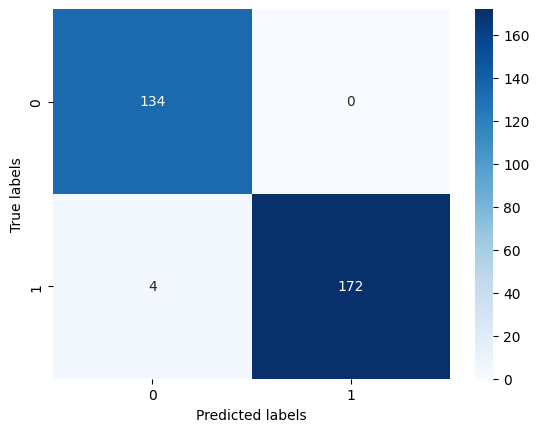

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get true labels and predicted labels from your model
# y_true = ... # true labels
# y_pred_prob_test = ... # predicted labels

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_prob_test)

# plot confusion matrix with classification
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

RESNET50 Model

In [ ]:
from keras.layers.regularization.dropout import Dropout
def brain_detection_model(input_shape):
    # Load pre-trained VGG model
    model = ResNet50(weights='imagenet', include_top=False, input_shape=(240, 240, 3))

    # Freeze the layers in the pre-trained VGG model
    for layer in model.layers:
        layer.trainable = False

    # Create a new input layer for your specific input shape
    input_layer = Input(shape=input_shape)

    # Use the pre-trained VGG model to extract features from your inputx = model(input_layer)
    x = model(input_layer)
    # Add your custom layers on top of the pre-trained VGG model
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='softmax')(x)

    # Create a new model using the input layer and your custom layers
    model = Model(inputs=input_layer, outputs=x)

    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)


In [ ]:
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [ ]:
model = brain_detection_model(IMG_SHAPE)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 256)               33554688  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 57,142,657
Trainable params: 33,554,945
Non-tra

In [ ]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001  # Specify the learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))
model.save("/content/drive/MyDrive/models/resnet1_model.h5")


Epoch 1/20
46/46 [==============================] - 24s 220ms/step - loss: 4.1058 - accuracy: 0.5308 - val_loss: 0.6910 - val_accuracy: 0.5065
Epoch 2/20
46/46 [==============================] - 6s 132ms/step - loss: 0.7113 - accuracy: 0.5308 - val_loss: 1.5323 - val_accuracy: 0.5065
Epoch 3/20
46/46 [==============================] - 6s 141ms/step - loss: 0.7318 - accuracy: 0.5308 - val_loss: 0.6897 - val_accuracy: 0.5065
Epoch 4/20
46/46 [==============================] - 6s 132ms/step - loss: 0.6786 - accuracy: 0.5308 - val_loss: 0.6890 - val_accuracy: 0.5065
Epoch 5/20
46/46 [==============================] - 6s 142ms/step - loss: 0.6875 - accuracy: 0.5308 - val_loss: 0.6893 - val_accuracy: 0.5065
Epoch 6/20
46/46 [==============================] - 6s 139ms/step - loss: 0.6881 - accuracy: 0.5308 - val_loss: 0.6904 - val_accuracy: 0.5065
Epoch 7/20
46/46 [==============================] - 6s 137ms/step - loss: 0.6877 - accuracy: 0.5308 - val_loss: 0.6897 - val_accuracy: 0.5065
Epoch

In [ ]:
best_model = load_model(filepath='/content/drive/MyDrive/models/resnet1_model.h5')

In [ ]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)


10/10 [==============================] - 2s 106ms/step - loss: 0.6925 - accuracy: 0.5194


In [ ]:
y_pred = best_model.predict(X_test)
# print(y_pred)
y_pred_prob_test = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test,y_pred_prob_test))

10/10 [==============================] - 2s 107ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       149
           1       0.52      1.00      0.68       161

    accuracy                           0.52       310
   macro avg       0.26      0.50      0.34       310
weighted avg       0.27      0.52      0.36       310



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
